In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap
import numpy as np
from typing import Dict, Iterable, Optional

from Simulation import Simulation 

In [2]:
# -------- Global style (journal look) --------
def _set_paper_style():
    sns.set_theme(style="whitegrid", font_scale=1.35)
    sns.set_palette("colorblind")
    plt.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 600,
        "axes.titleweight": "bold",
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.frameon": False,
        "legend.title_fontsize": 12,
        "legend.fontsize": 11
    })

# -------- Helpers --------
def _to_long_df(estimates: Dict[str, np.ndarray],
                y_true: float,
                allocations: Iterable[str]) -> pd.DataFrame:
    """
    Build a tidy DataFrame from arrays of estimates and allocation labels.
    `estimates` must contain keys 'Y_SM' and 'Y_PML' mapping to 1D arrays of equal length.
    `allocations` is a list/array of same length with allocation strategy per run.
    """
    Y_SM = np.asarray(estimates["Y_SM"])
    Y_PML = np.asarray(estimates["Y_PML"])
    alloc = np.asarray(list(allocations))
    assert Y_SM.shape == Y_PML.shape == alloc.shape, "Arrays must have same length."

    df = pd.DataFrame({
        "Y_SM": Y_SM,
        "Y_PML": Y_PML,
        "allocation": alloc
    })
    # long format for plotting
    df_long = df.melt(id_vars="allocation", value_vars=["Y_SM", "Y_PML"],
                      var_name="Estimator", value_name="Estimate")
    df_long["Estimator"] = df_long["Estimator"].str.replace("Y_", "", regex=False)
    df_long["Y_true"] = y_true
    df_long["RelError"] = (df_long["Estimate"] - y_true) / y_true
    return df_long

def _mse_group(df_long: pd.DataFrame, n_boot: int = 5000) -> pd.DataFrame:
    """
    Compute MSE per (allocation, Estimator) and return 95% CI via bootstrap.
    
    Parameters
    ----------
    df_long : pd.DataFrame
        Must contain columns ["allocation", "Estimator", "Estimate", "Y_true"].
    n_boot : int
        Number of bootstrap resamples.
    
    Returns
    -------
    pd.DataFrame
        Columns: ["allocation", "Estimator", "MSE", "CI_low", "CI_high", "n"]
    """
    tmp = df_long.assign(SE=lambda d: (d["Estimate"] - d["Y_true"])**2)
    out_rows = []

    for (alloc, est), group in tmp.groupby(["allocation", "Estimator"]):
        se_values = group["SE"].values
        n = len(se_values)
        
        # Bootstrap the mean of squared errors
        res = bootstrap((se_values,), np.mean, confidence_level=0.95, n_resamples=n_boot, method='percentile')
        mse = se_values.mean()
        ci_low, ci_high = res.confidence_interval.low, res.confidence_interval.high
        
        out_rows.append({
            "allocation": alloc,
            "Estimator": est,
            "MSE": mse,
            "CI_low": ci_low,
            "CI_high": ci_high,
            "n": n
        })
    
    return pd.DataFrame(out_rows)

In [3]:
#this serves to initialize
simulation = Simulation(allocation="equal")
simulation_init_results = simulation.run_pipeline()

simulation_opt = Simulation(allocation="optimal_cost")
simulation_init_results_opt = simulation_opt.run_pipeline()


Y_true = np.sum(simulation_init_results["population"]["y"])
Nq_true_equal = np.sum(simulation_init_results["population"]["Nq"])

In [4]:
# Suppose you have arrays from R runs with the same length:
R = 100
estimates = {
     "Y_SM": np.hstack([np.array([Simulation(reproduce=False, allocation= "equal").run_pipeline()["estimates"]["Y_SM"] for rr in range(R)]), 
                       np.array([Simulation(reproduce=False, allocation= "optimal_cost").run_pipeline()["estimates"]["Y_SM"] for rr in range(R)])]),
     "Y_PML": np.hstack([np.array([Simulation(reproduce=False, allocation= "equal").run_pipeline()["estimates"]["Y_PML"] for rr in range(R)]), 
                       np.array([Simulation(reproduce=False, allocation= "optimal_cost").run_pipeline()["estimates"]["Y_PML"] for rr in range(R)])]),
      "N_hatq": np.vstack([np.array([Simulation(reproduce=False, allocation= "equal").run_pipeline()["estimates"]["Nhat_q"] for rr in range(R)]), 
                       np.array([Simulation(reproduce=False, allocation= "optimal_cost").run_pipeline()["estimates"]["Nhat_q"] for rr in range(R)])]),
    "NPML_d": np.vstack([np.array([Simulation(reproduce=False, allocation= "equal").run_pipeline()["estimates"]["NPML_d"] for rr in range(R)]), 
                       np.array([Simulation(reproduce=False, allocation= "optimal_cost").run_pipeline()["estimates"]["NPML_d"] for rr in range(R)])]),
}

allocations = np.hstack([np.repeat("equal", R), np.repeat("optimal_cost", R)])  # e.g., ["prop-x", "equal", "cost-opt", ...] per run


#
#plot_estimator_distribution(estimates, Y_true, allocations, kind="boxplot", save="fig_test.pdf")
#plot_relative_error(estimates, Y_true, allocations, save="fig_test.pdf")
#plot_mse(estimates, Y_true, allocations, save="fig_test.pdf")

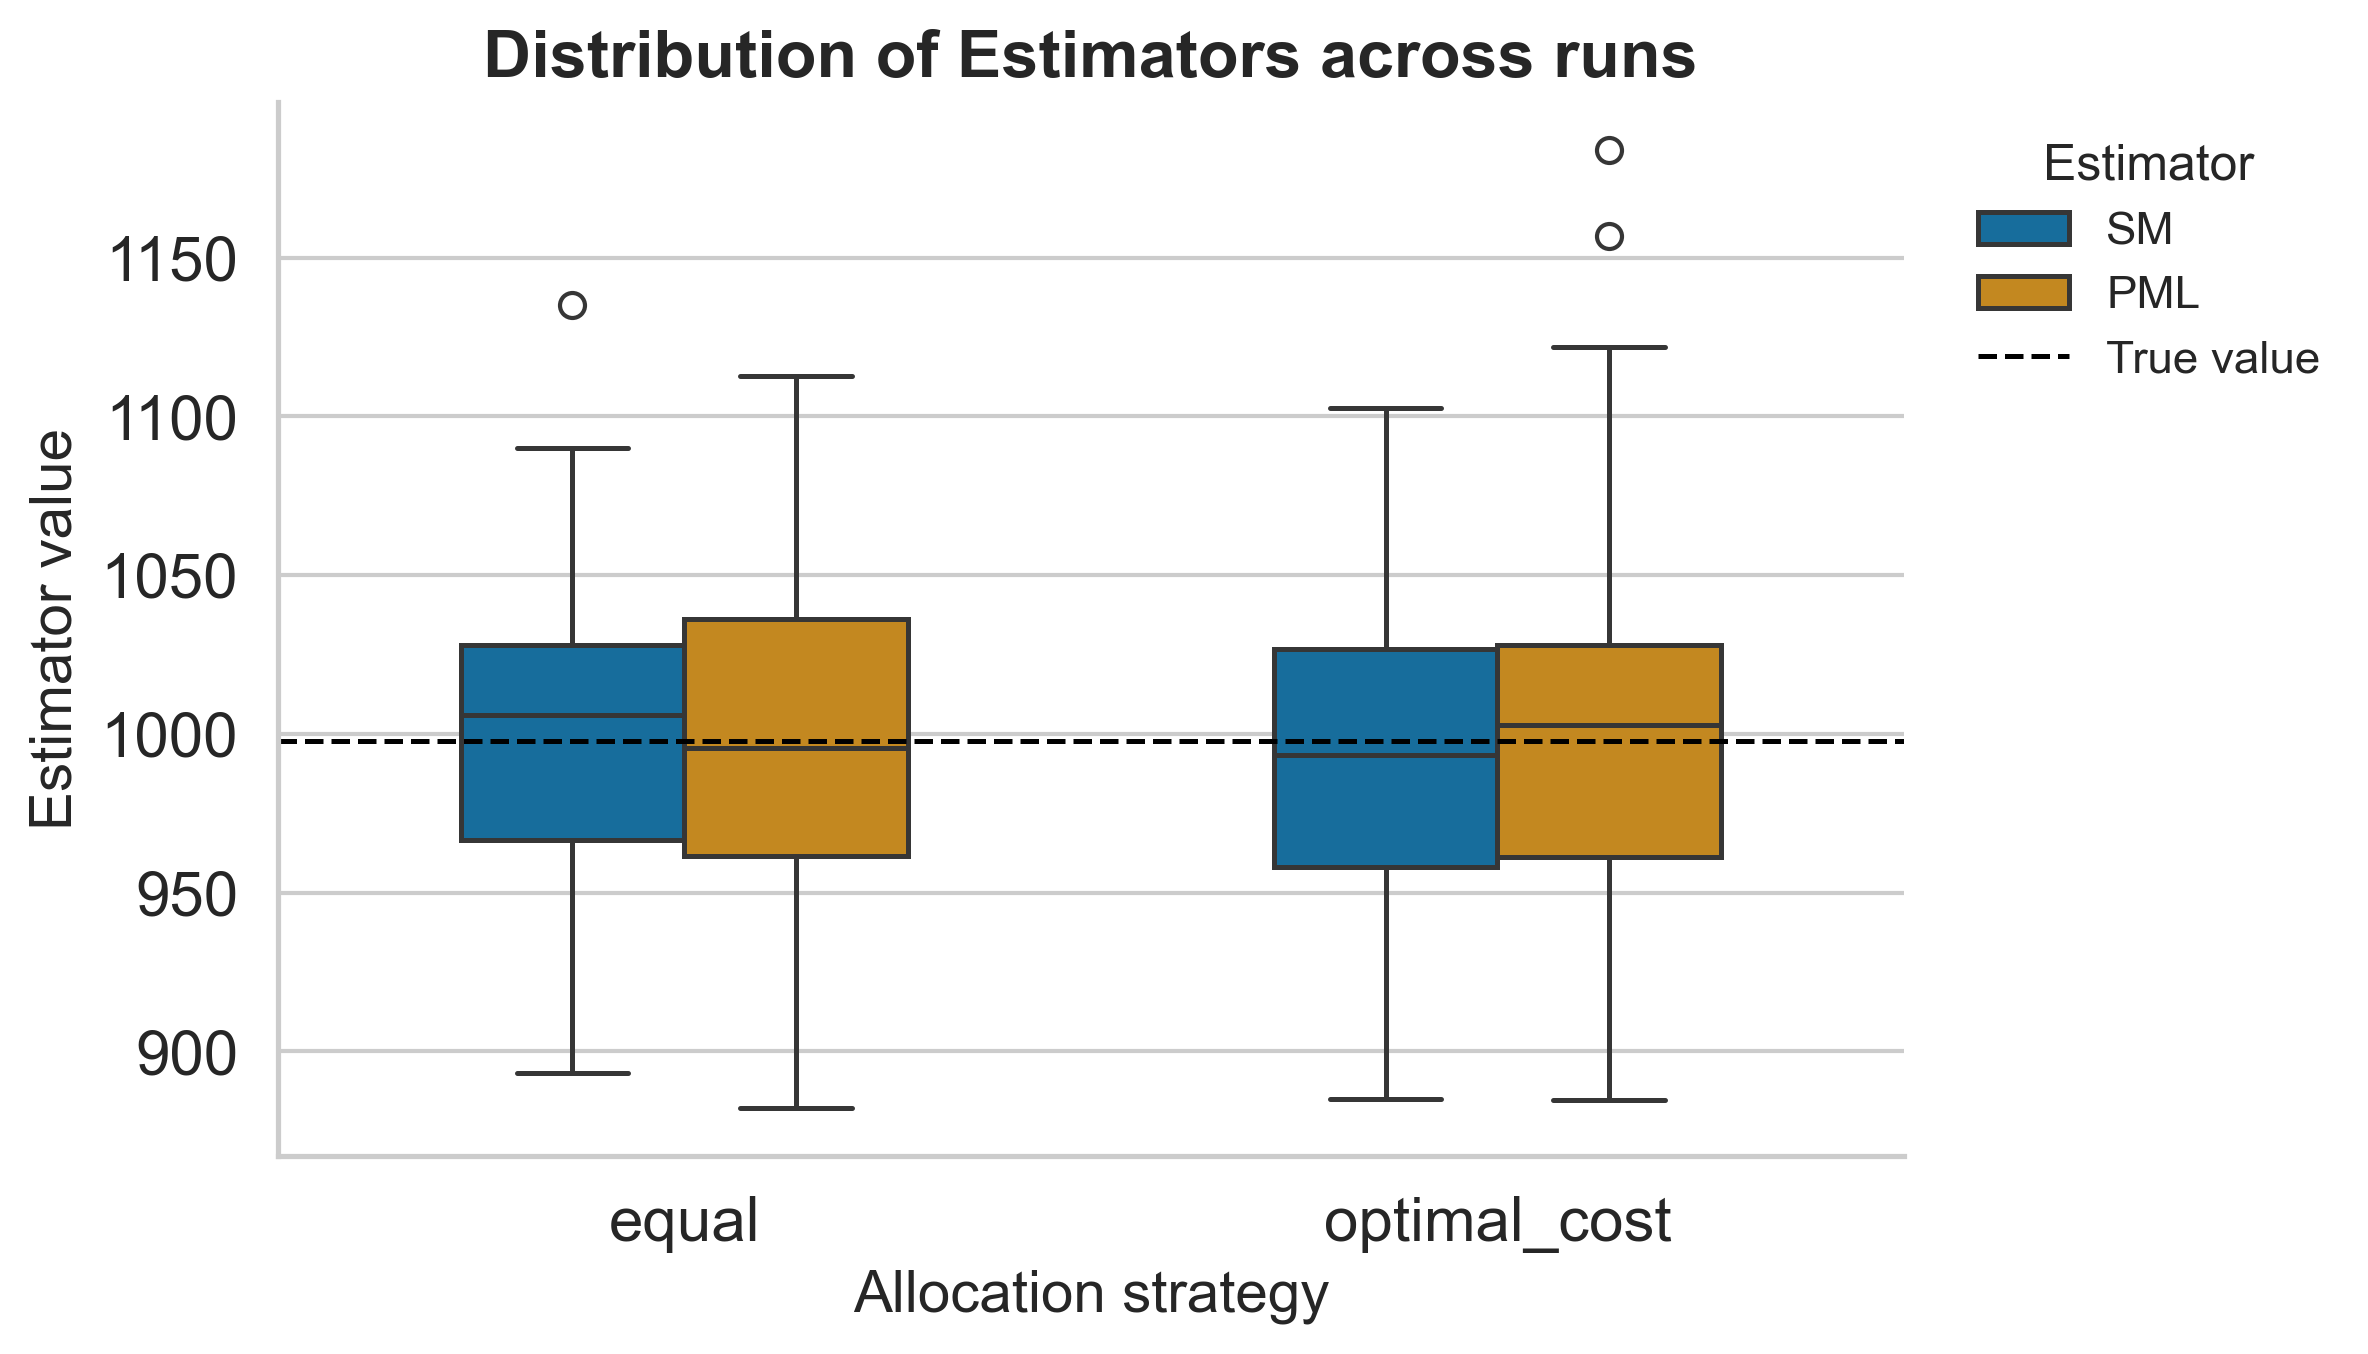

In [5]:
def plot_estimator_distribution(estimates: Dict[str, np.ndarray],
                                y_true: float,
                                allocations: Iterable[str],
                                kind: str = "violin",
                                save: Optional[str] = None):
    """
    Distribution of Y_SM vs Y_PML across runs, split by allocation.
    kind: 'violin' or 'box'
    """
    _set_paper_style()
    df = _to_long_df(estimates, y_true, allocations)

    plt.figure(figsize=(8.2, 4.8))
    if kind == "violin":
        ax = sns.violinplot(data=df, x="allocation", y="Estimate", hue="Estimator",
                            inner="quartile", cut=0)
    else:
        ax = sns.boxplot(data=df, x="allocation", y="Estimate", hue="Estimator",
                         width=0.55, linewidth=1.2)
    # True line
    ax.axhline(y_true, color="black", linestyle="--", linewidth=1.2, label="True value")
    ax.set_xlabel("Allocation strategy")
    ax.set_ylabel("Estimator value")
    ax.set_title("Distribution of Estimators across runs")
    # combine legend entries (avoid duplicate line handle)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02, 1), loc="upper left", title="Estimator")
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()
    
plot_estimator_distribution(estimates, Y_true, allocations, kind="boxplot", save="Estimator_distribution.pdf")

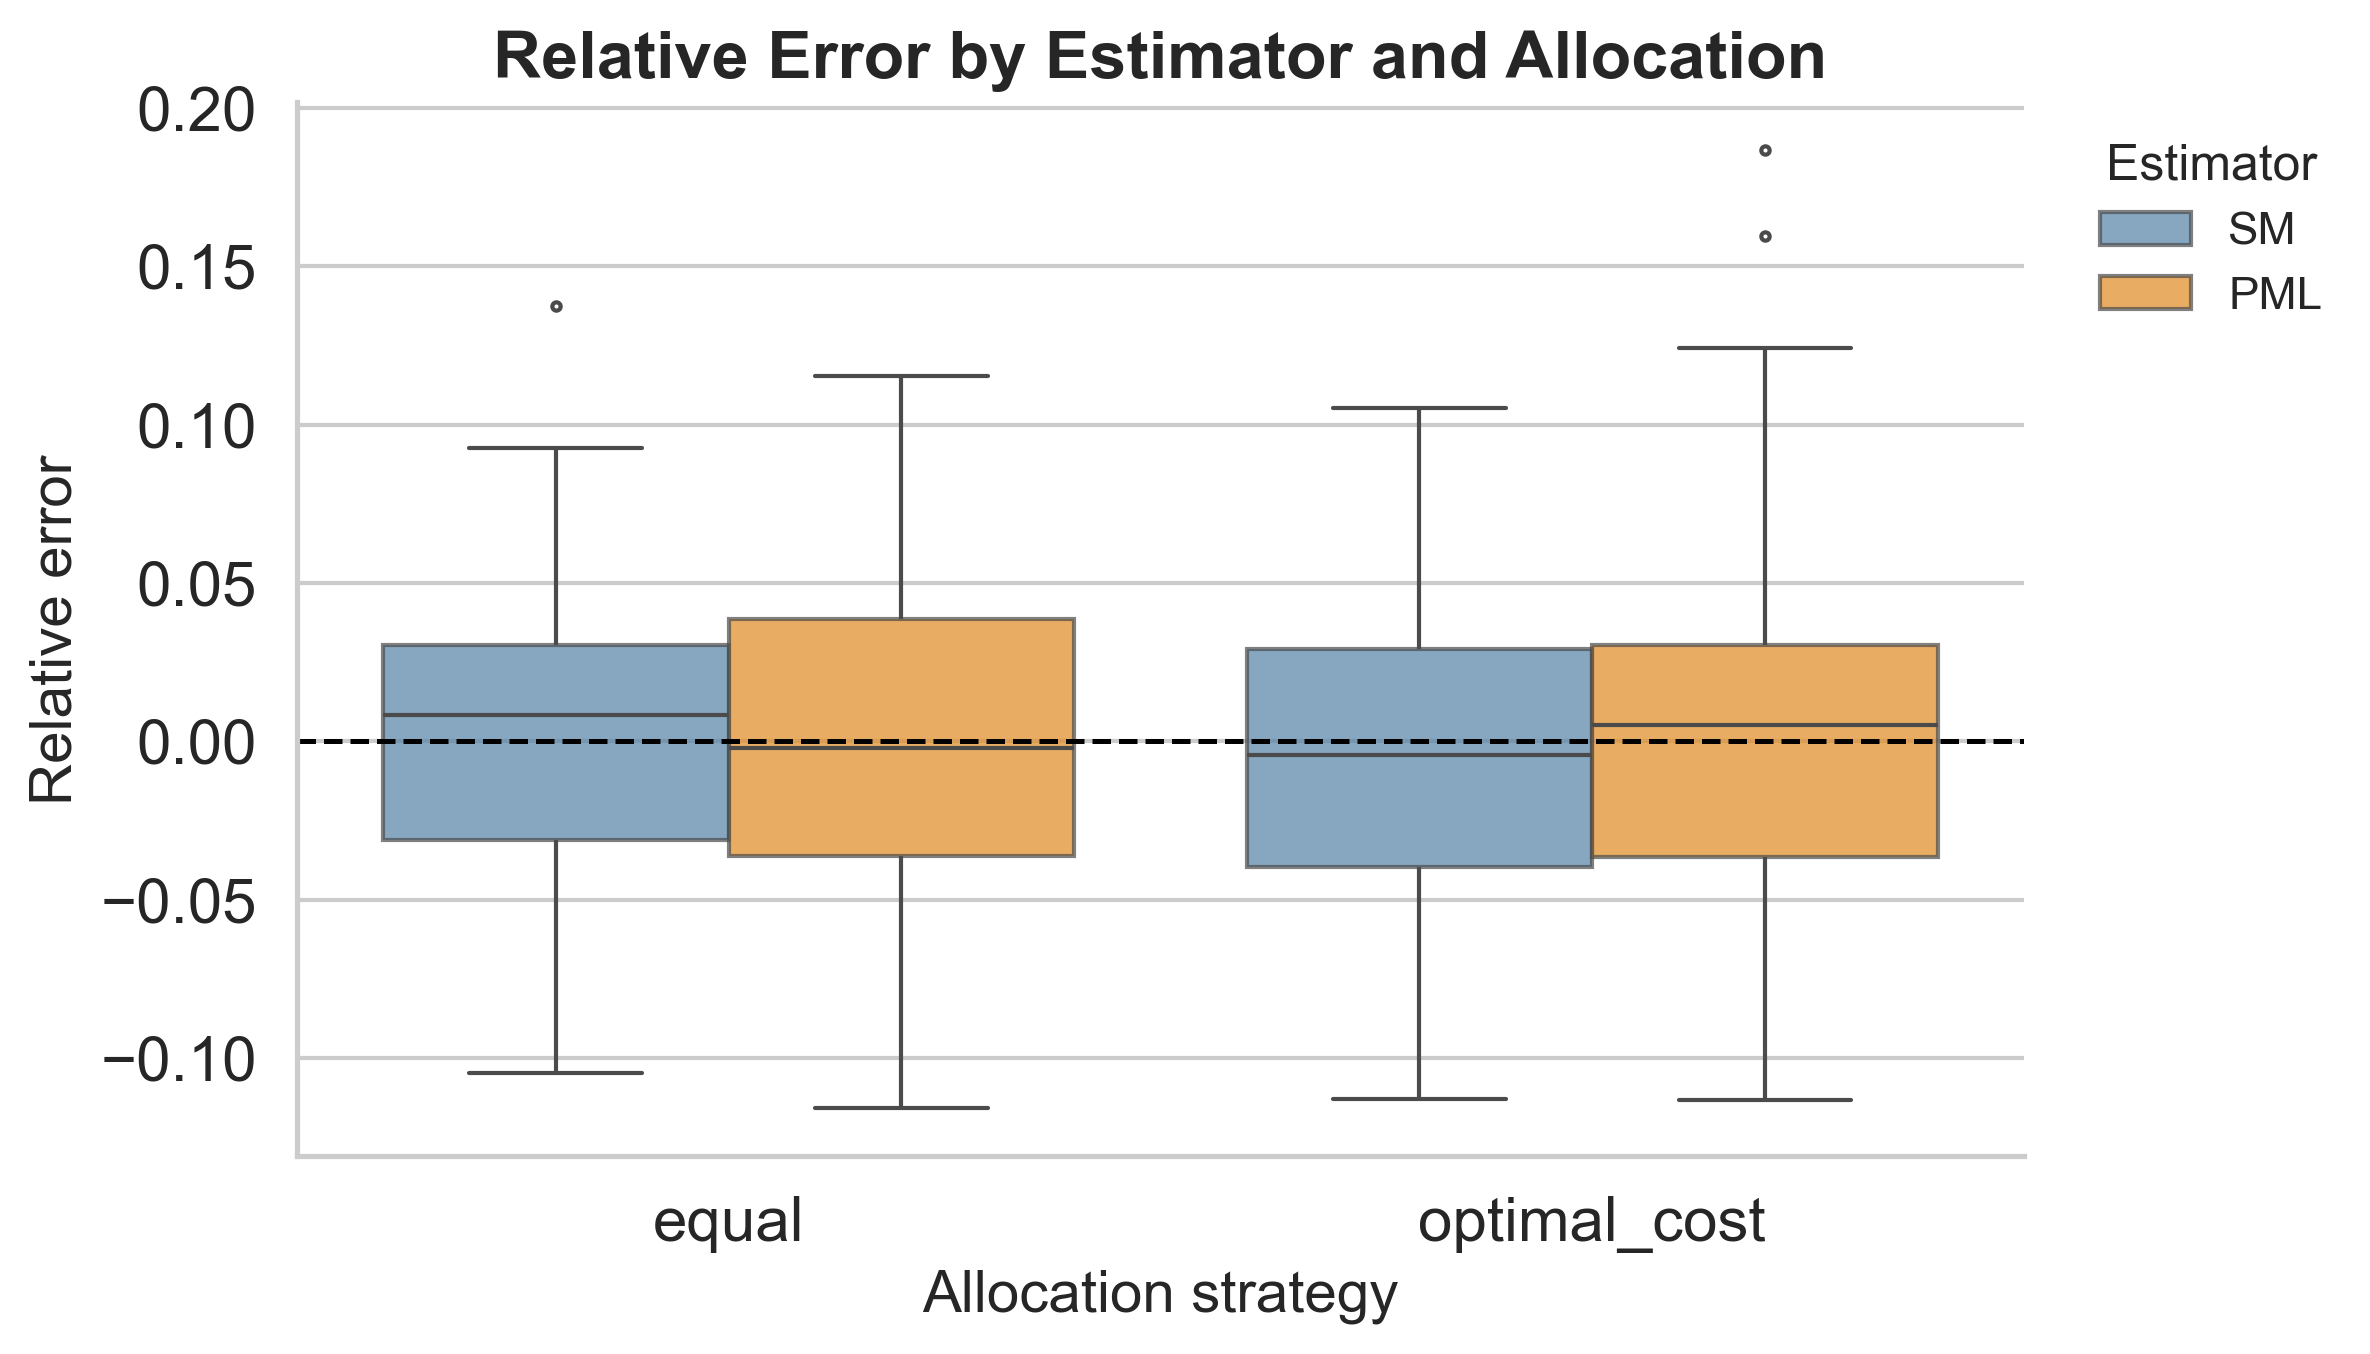

In [6]:
def plot_relative_error(estimates: Dict[str, np.ndarray],
                        y_true: float,
                        allocations: Iterable[str],
                        save: Optional[str] = None):
    """
    Relative error = (estimate - Y_true)/Y_true for SM vs PML, per allocation.
    """
    _set_paper_style()
    df = _to_long_df(estimates, y_true, allocations)

    plt.figure(figsize=(8.2, 4.8))
    ax = sns.boxplot(
        data=df,
        x="allocation",
        y="RelError",
        hue="Estimator",
        palette=["steelblue", "darkorange"],
        showcaps=True,
        fliersize=2,
        boxprops={"alpha": 0.7}
    )
    ax.axhline(0, color="black", linestyle="--", linewidth=1.2)
    ax.set_xlabel("Allocation strategy")
    ax.set_ylabel("Relative error")
    ax.set_title("Relative Error by Estimator and Allocation")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Estimator")

    sns.despine()
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()


plot_relative_error(estimates, Y_true, allocations, save="Relative_error.pdf")

     allocation Estimator          MSE       CI_low      CI_high    n
0         equal       PML  2443.514149  1862.894178  3053.916781  100
1         equal        SM  2002.814028  1491.944475  2597.246248  100
2  optimal_cost       PML  2933.918652  2036.573697  4041.262265  100
3  optimal_cost        SM  2229.161679  1736.346312  2778.044977  100


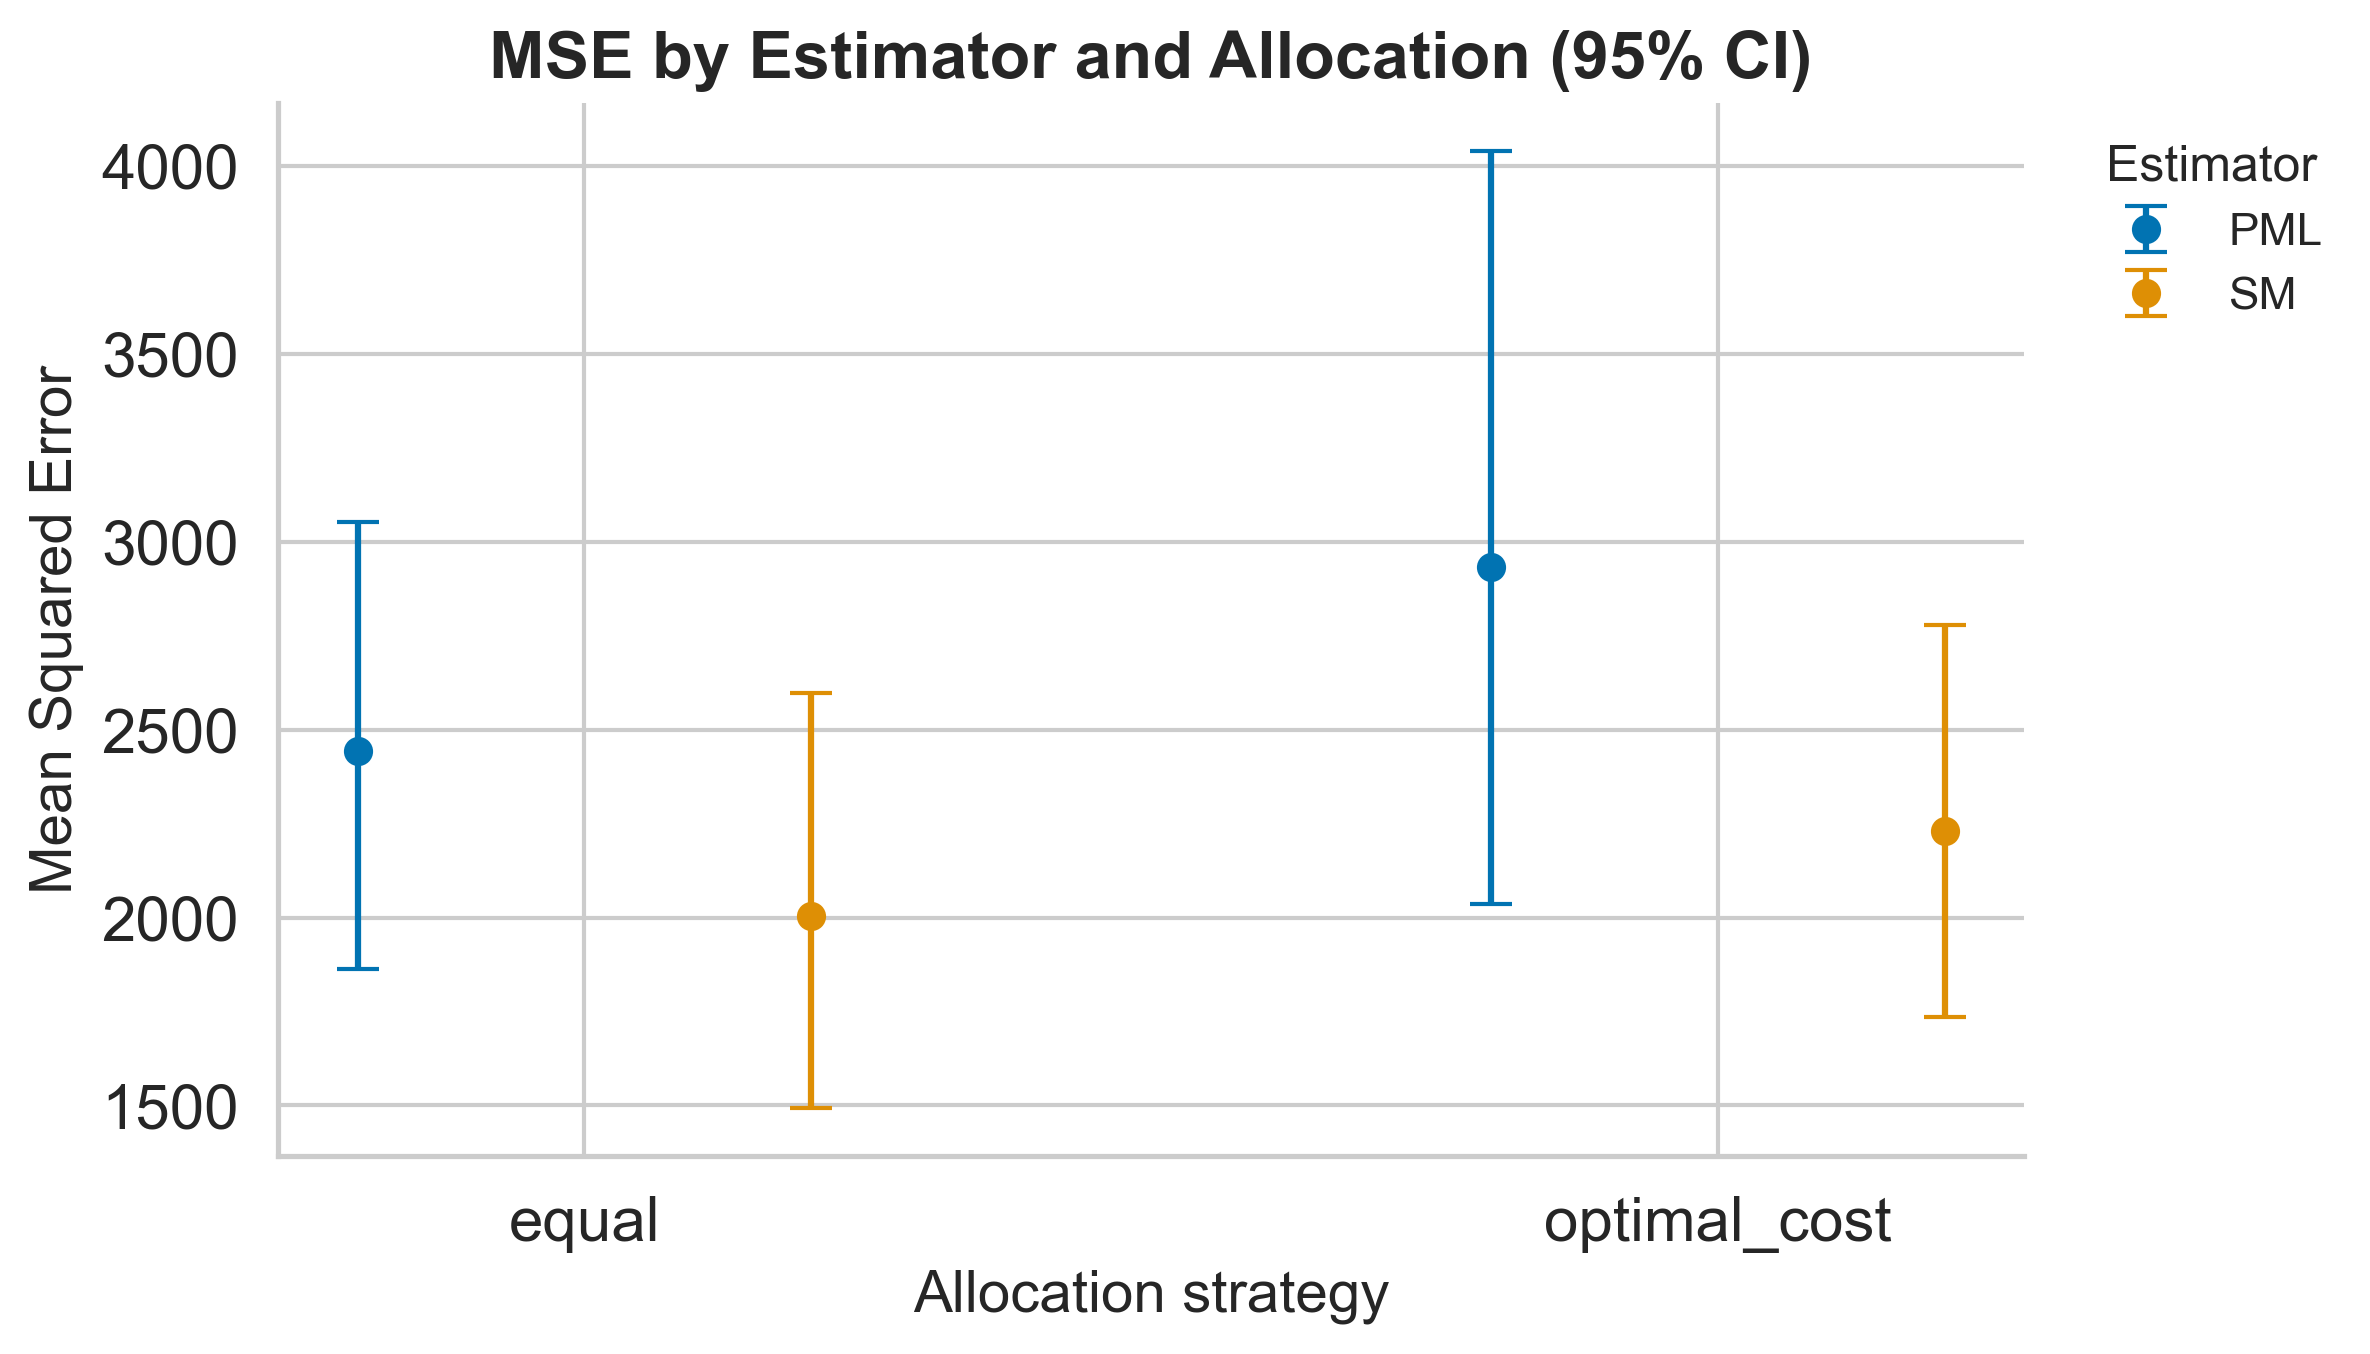

In [7]:
def plot_mse(estimates: Dict[str, np.ndarray],
             y_true: float,
             allocations: Iterable[str],
             save: Optional[str] = None):
    """
    Plot MSE per estimator and allocation using pre-computed bootstrap CI.
    """
    _set_paper_style()
    df = _to_long_df(estimates, y_true, allocations)
    mse_df = _mse_group(df)

    print(mse_df)
    
    plt.figure(figsize=(8.2, 4.8))
    
    # Get unique estimators and allocations for positioning
    estimators = mse_df["Estimator"].unique()
    allocations_list = mse_df["allocation"].unique()
    n_alloc = len(allocations_list)
    width = 0.8 / len(estimators)  # width of each point
    
    for i, est in enumerate(estimators):
        est_df = mse_df[mse_df["Estimator"] == est]
        x = np.arange(n_alloc) - 0.4 + i * width + width/2
        y = est_df["MSE"]
        yerr = [y - est_df["CI_low"], est_df["CI_high"] - y]  # asymmetric error bars
        plt.errorbar(
            x, y, yerr=yerr, fmt='o', label=est, capsize=5
        )
    
    plt.xticks(np.arange(n_alloc), allocations_list)
    plt.xlabel("Allocation strategy")
    plt.ylabel("Mean Squared Error")
    plt.title("MSE by Estimator and Allocation (95% CI)")
    plt.legend(title="Estimator", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

plot_mse(estimates, Y_true, allocations, save="MSE.pdf")

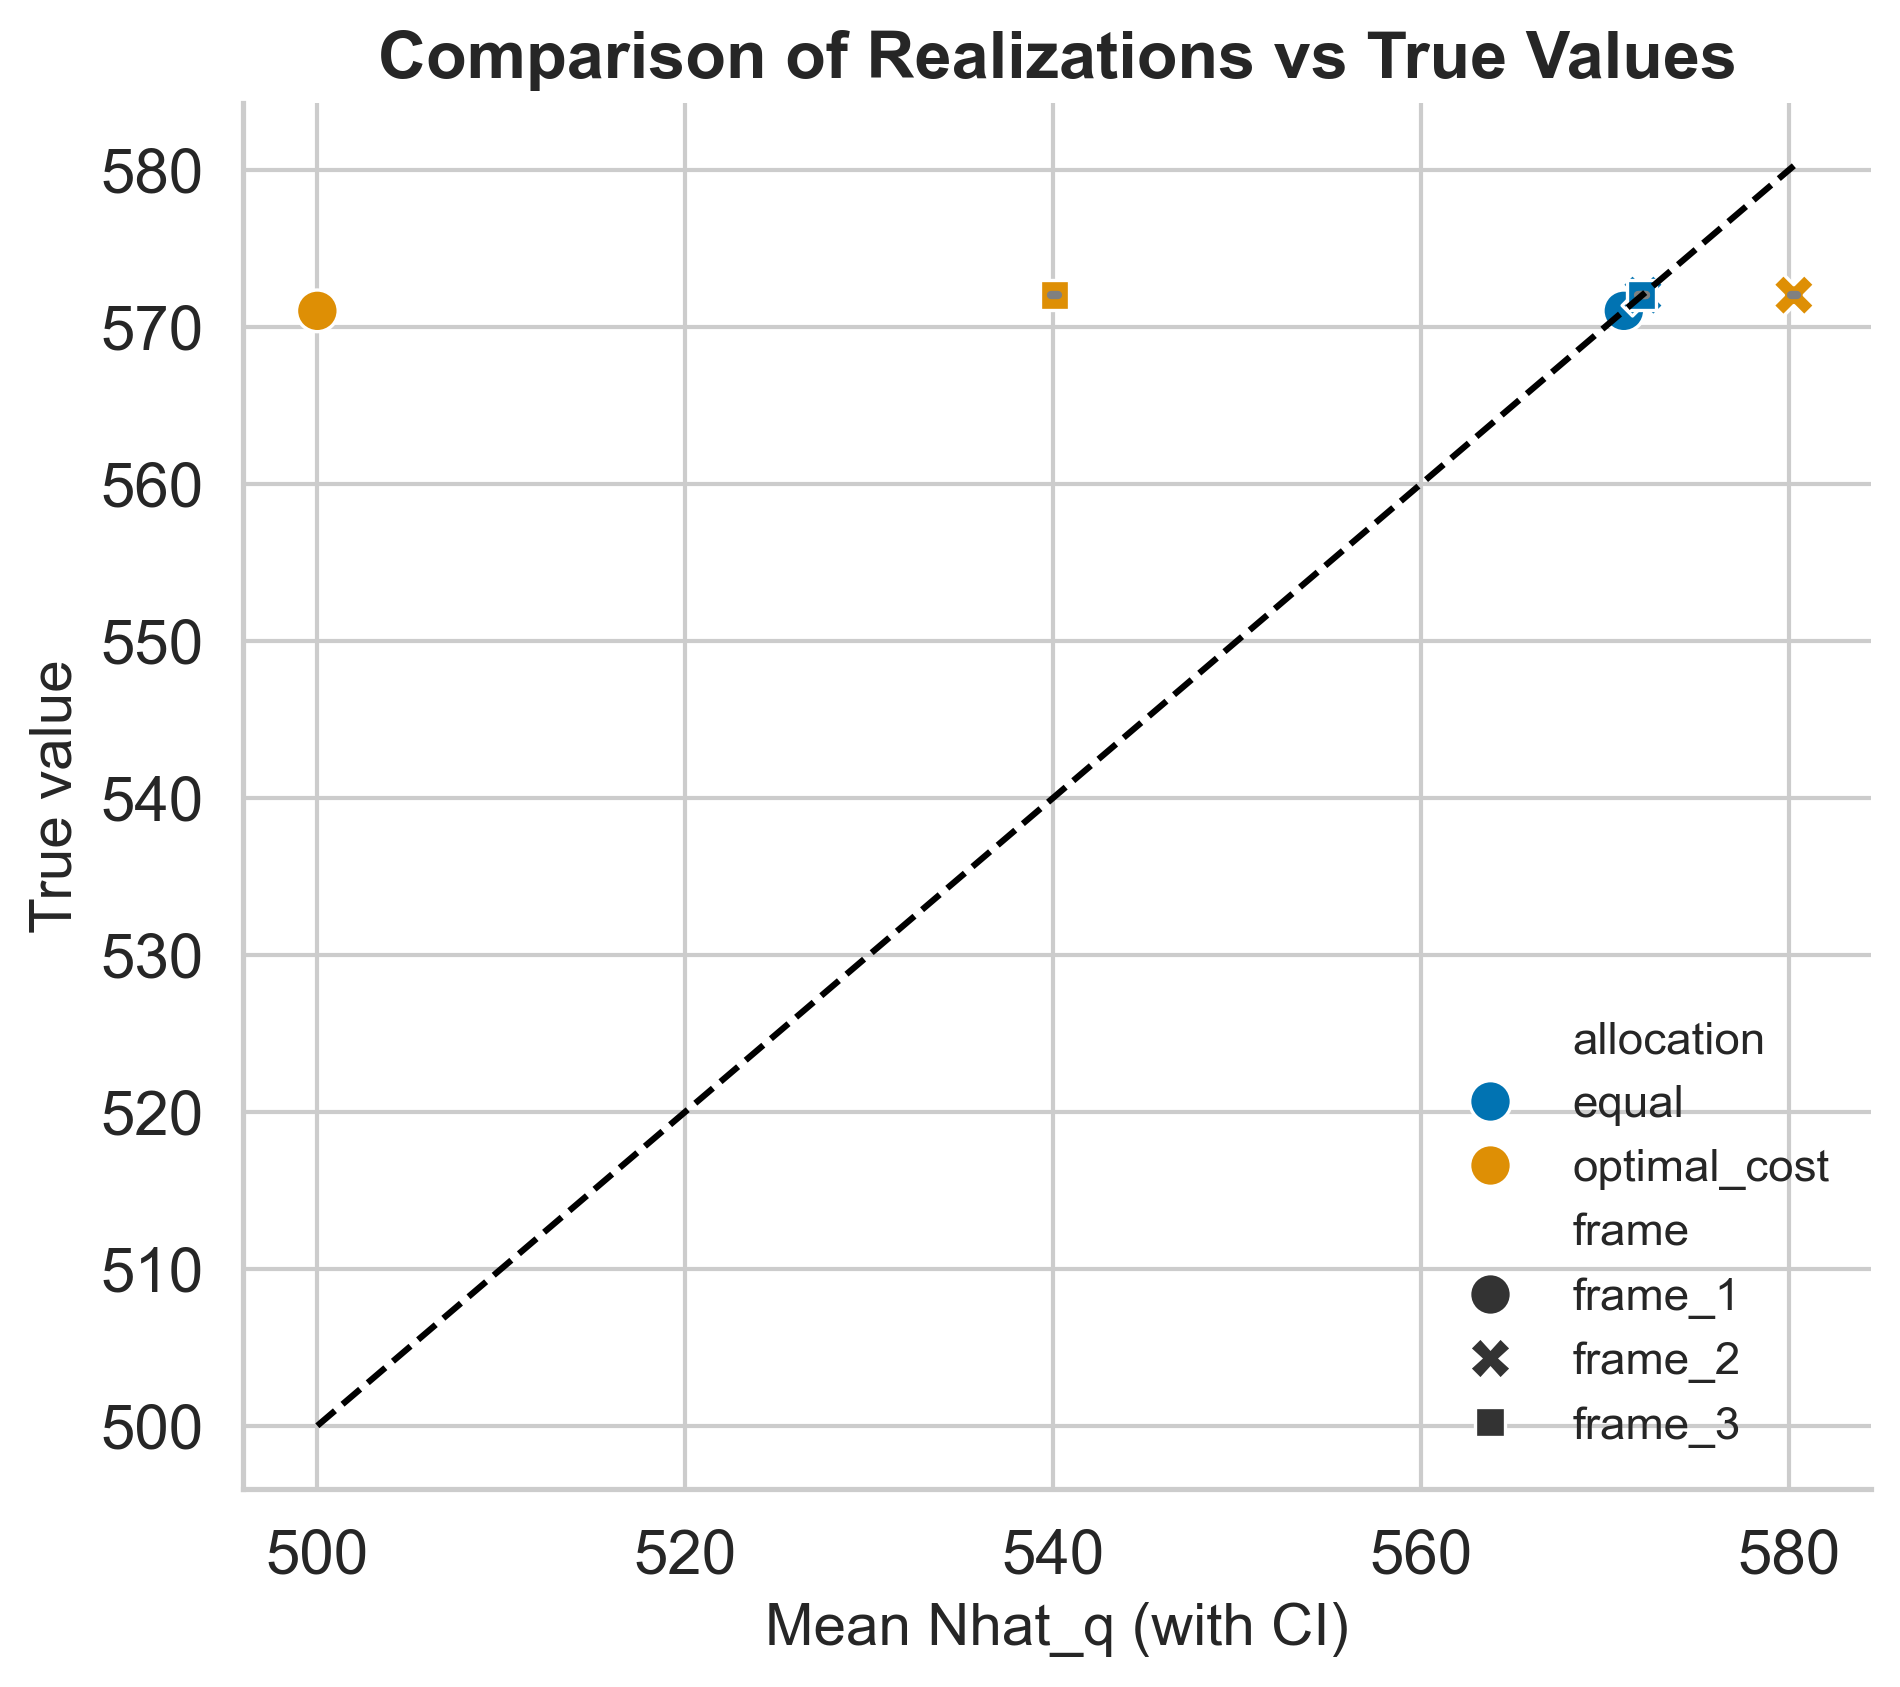

,allocation,frame,mean_x,ci_low,ci_high,true_y
0,equal,frame_1,571.000000,571.000000,571.000000,571
1,equal,frame_2,572.038279,571.866931,572.198903,572
2,equal,frame_3,571.972203,571.746575,572.207001,572
3,optimal_cost,frame_1,500.000000,500.000000,500.000000,571
4,optimal_cost,frame_2,580.239835,580.076612,580.405811,572
5,optimal_cost,frame_3,540.066483,539.846944,540.269526,572


<Figure size 1920x1440 with 0 Axes>

In [8]:
def frame_size_reconstruction(realizations, modalities, true_values, n_boot=2000, ci_level=0.95, save: Optional[str] = None):
    """
    Compare realizations of x (N samples x M variables) with true values y.
    Computes mean and bootstrap CI per modality and variable.
    
    Parameters
    ----------
    realizations : ndarray (N x M)
        Realizations of x values.
    modalities : array-like (length N)
        Labels indicating modality of each row.
    true_values : array-like (length M)
        True reference values y1..yM.
    n_boot : int, optional
        Number of bootstrap resamples.
    ci_level : float, optional
        Confidence interval level (default 0.95).
        
    Returns
    -------
    df_summary : DataFrame
        Mean, CI, and comparison with truth for each modality-variable.
    """
    N, M = realizations.shape
    modalities = np.array(modalities)
    true_values = np.array(true_values)
    
    results = []
    for mod in np.unique(modalities):
        mod_idx = modalities == mod
        X_mod = realizations[mod_idx]  # subset
        
        for j in range(M):
            col = X_mod[:, j]
            
            # bootstrap CI for the mean
            boot_res = bootstrap(
                (col,), 
                np.mean, 
                confidence_level=ci_level, 
                n_resamples=n_boot, 
                method="percentile"
            )
            
            mean_val = np.mean(col)
            ci_low, ci_high = boot_res.confidence_interval
            
            results.append({
                "allocation": mod,
                "frame": f"frame_{j+1}",
                "mean_x": mean_val,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "true_y": true_values[j]
            })
    
    df_summary = pd.DataFrame(results)
    
    # Plotting: scatter with CI bars
    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df_summary, x="mean_x", y="true_y", hue="allocation", style="frame", s=100)
    
    # error bars for CI
    for _, row in df_summary.iterrows():
        plt.plot([row["ci_low"], row["ci_high"]], [row["true_y"]]*2, color="gray", lw=2)
    
    # 45 degree line
    lims = [
        min(df_summary["mean_x"].min(), df_summary["true_y"].min()),
        max(df_summary["mean_x"].max(), df_summary["true_y"].max())
    ]
    plt.plot(lims, lims, "--", color="black")
    plt.xlabel("Mean Nhat_q (with CI)")
    plt.ylabel("True value")
    plt.title("Comparison of Realizations vs True Values")
    plt.show()

    if save:
        plt.savefig(save, bbox_inches="tight")
    
    return df_summary


frame_size_reconstruction(estimates["N_hatq"], allocations,
                          np.array([len(item) for item in simulation_init_results ["population"]["frames"]]), 
                         save = "frame_size_reconstruction.pdf")

In [9]:
np.array([len(item) for item in simulation_init_results ["population"]["frames"]])

array([571, 572, 572])

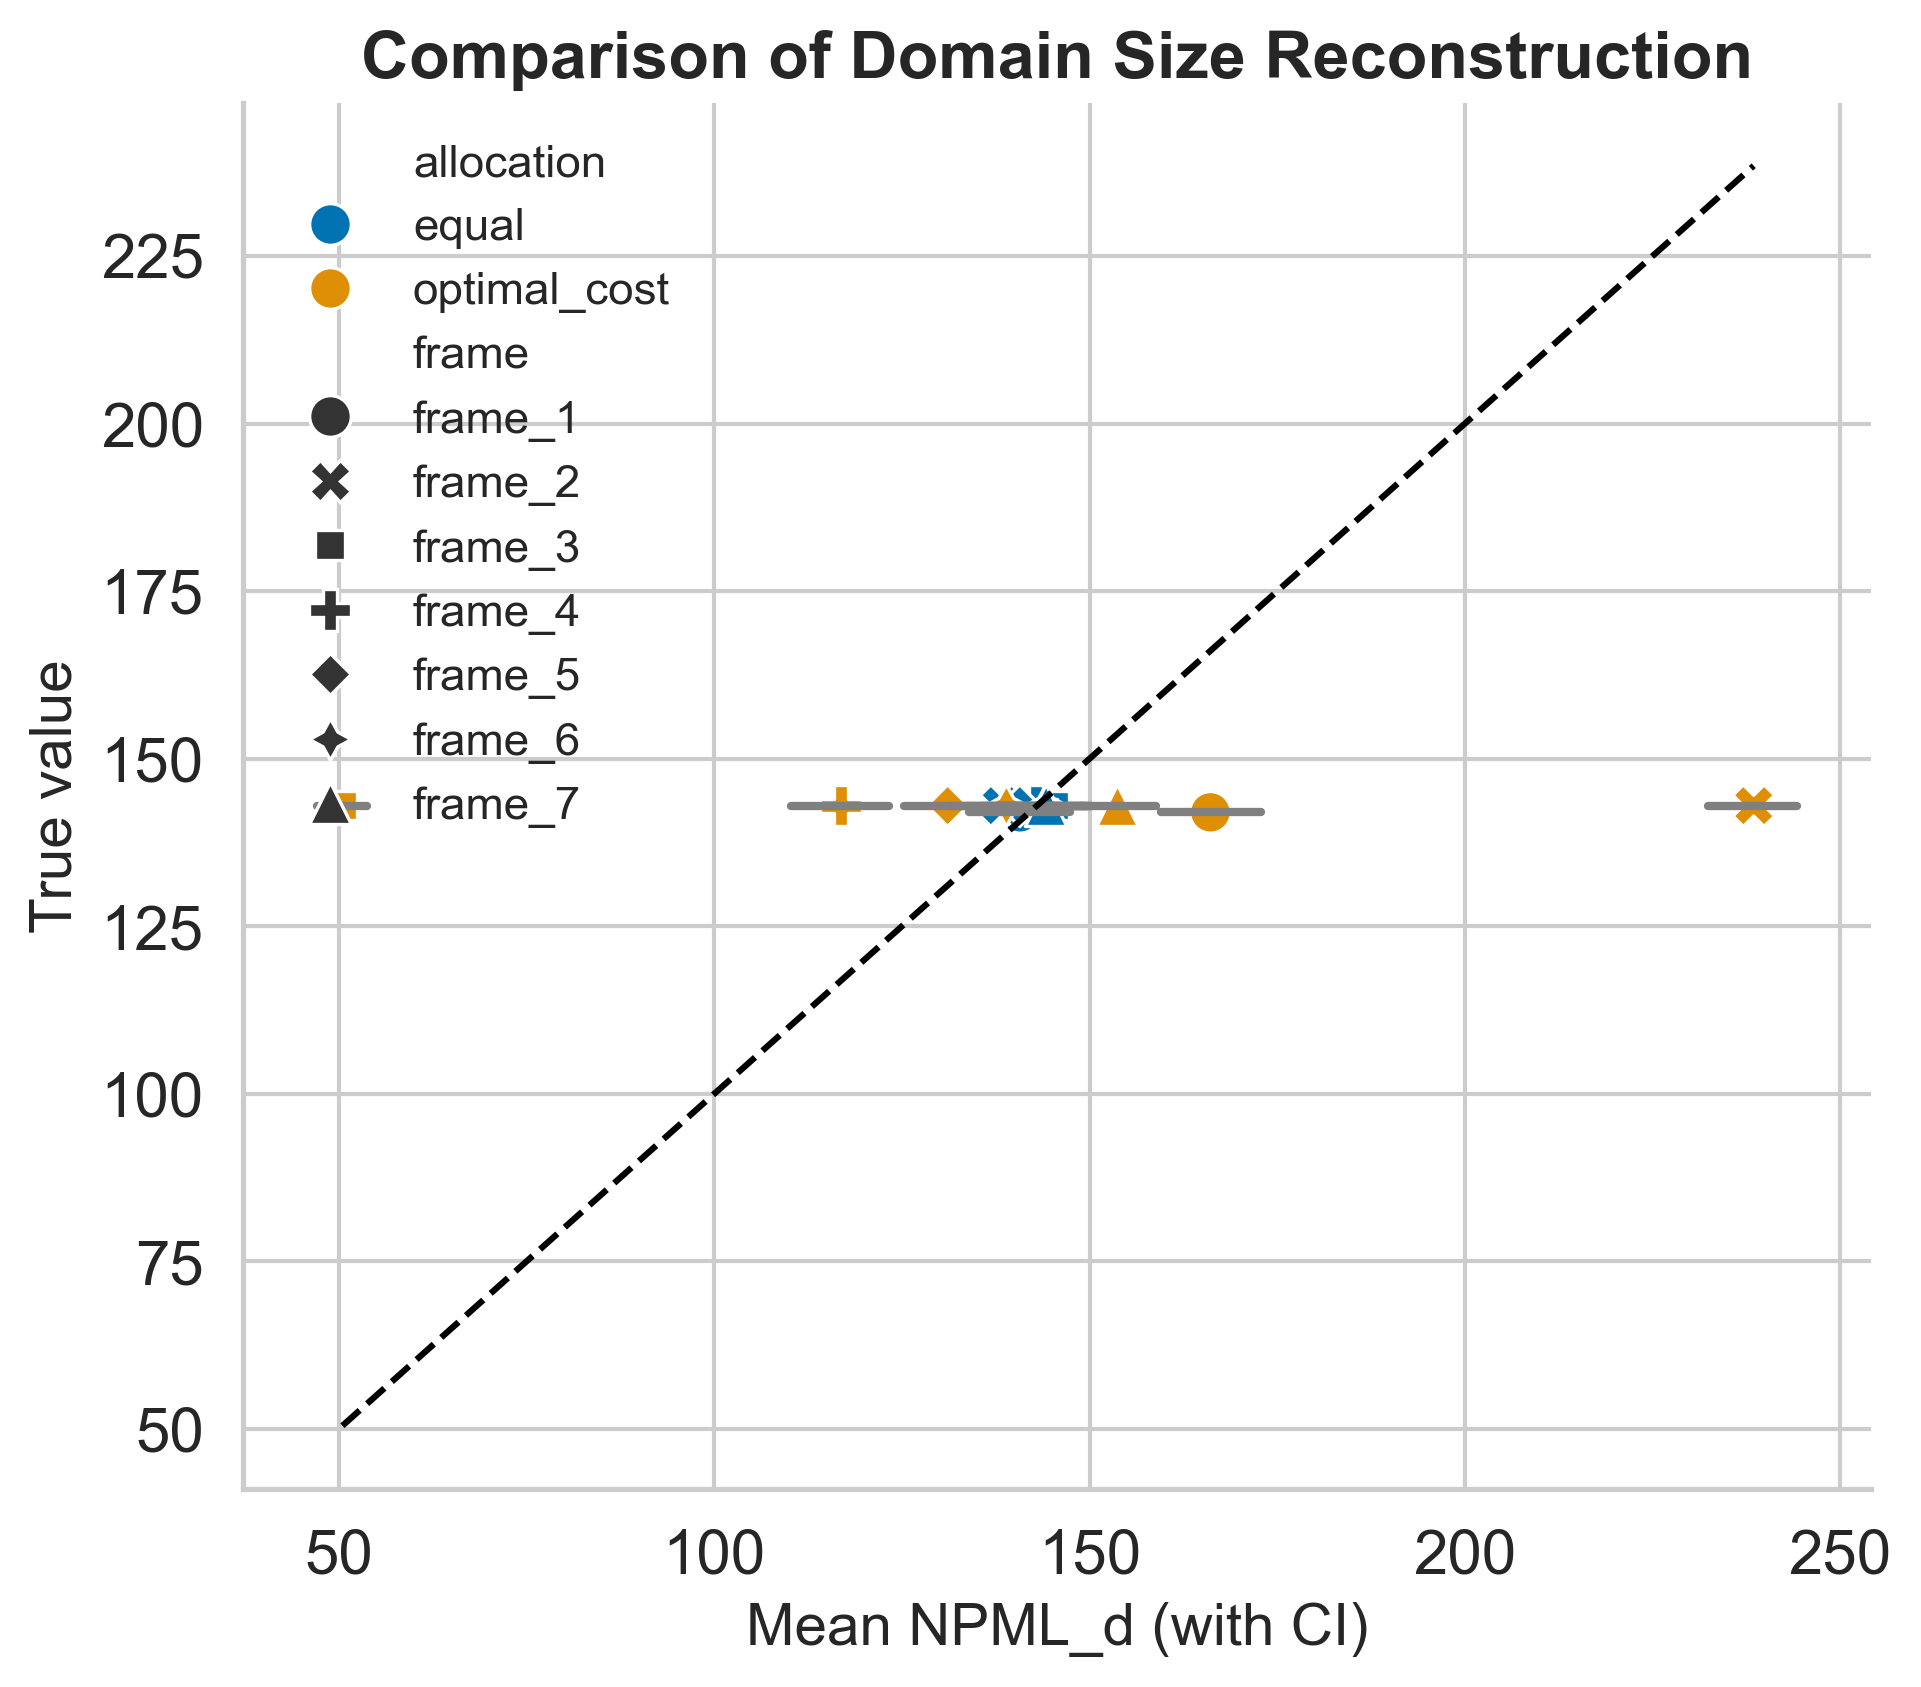

,allocation,frame,mean_x,ci_low,ci_high,true_y
0,equal,frame_1,140.747517,134.005332,147.431543,142
1,equal,frame_2,138.246070,130.997568,145.398009,143
2,equal,frame_3,145.310462,140.112053,150.360695,143
3,equal,frame_4,142.840851,136.171998,149.907905,143
4,equal,frame_5,140.715682,135.497919,146.271428,143
5,equal,frame_6,144.217129,138.939194,149.674601,143
6,equal,frame_7,144.226339,138.963360,149.597705,143
7,optimal_cost,frame_1,166.105439,159.524687,172.826925,142
8,optimal_cost,frame_2,238.490053,232.379178,244.244505,143
9,optimal_cost,frame_3,50.465540,47.126079,53.806210,143


<Figure size 1920x1440 with 0 Axes>

In [10]:
def domain_size_reconstruction(realizations, modalities, true_values, n_boot=2000, ci_level=0.95, save: Optional[str] = None):
    """
    Compare realizations of x (N samples x M variables) with true values y.
    Computes mean and bootstrap CI per modality and variable.
    
    Parameters
    ----------
    realizations : ndarray (N x M)
        Realizations of x values.
    modalities : array-like (length N)
        Labels indicating modality of each row.
    true_values : array-like (length M)
        True reference values y1..yM.
    n_boot : int, optional
        Number of bootstrap resamples.
    ci_level : float, optional
        Confidence interval level (default 0.95).
        
    Returns
    -------
    df_summary : DataFrame
        Mean, CI, and comparison with truth for each modality-variable.
    """
    N, M = realizations.shape
    modalities = np.array(modalities)
    true_values = np.array(true_values)
    
    results = []
    for mod in np.unique(modalities):
        mod_idx = modalities == mod
        X_mod = realizations[mod_idx]  # subset
        
        for j in range(M):
            col = X_mod[:, j]
            
            # bootstrap CI for the mean
            boot_res = bootstrap(
                (col,), 
                np.mean, 
                confidence_level=ci_level, 
                n_resamples=n_boot, 
                method="percentile"
            )
            
            mean_val = np.mean(col)
            ci_low, ci_high = boot_res.confidence_interval
            
            results.append({
                "allocation": mod,
                "frame": f"frame_{j+1}",
                "mean_x": mean_val,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "true_y": true_values[j]
            })
    
    df_summary = pd.DataFrame(results)
    
    # Plotting: scatter with CI bars
    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df_summary, x="mean_x", y="true_y", hue="allocation", style="frame", s=100)
    
    # error bars for CI
    for _, row in df_summary.iterrows():
        plt.plot([row["ci_low"], row["ci_high"]], [row["true_y"]]*2, color="gray", lw=2)
    
    # 45 degree line
    lims = [
        min(df_summary["mean_x"].min(), df_summary["true_y"].min()),
        max(df_summary["mean_x"].max(), df_summary["true_y"].max())
    ]
    plt.plot(lims, lims, "--", color="black")
    plt.xlabel("Mean NPML_d (with CI)")
    plt.ylabel("True value")
    plt.title("Comparison of Domain Size Reconstruction")
    plt.show()

    if save:
        plt.savefig(save, bbox_inches="tight")
    
    return df_summary

domain_size_reconstruction(estimates["NPML_d"], allocations, np.array([len(item) for item in simulation_init_results ["population"]["domains"]]), 
                          save = "domain_size_reconstruction.pdf")

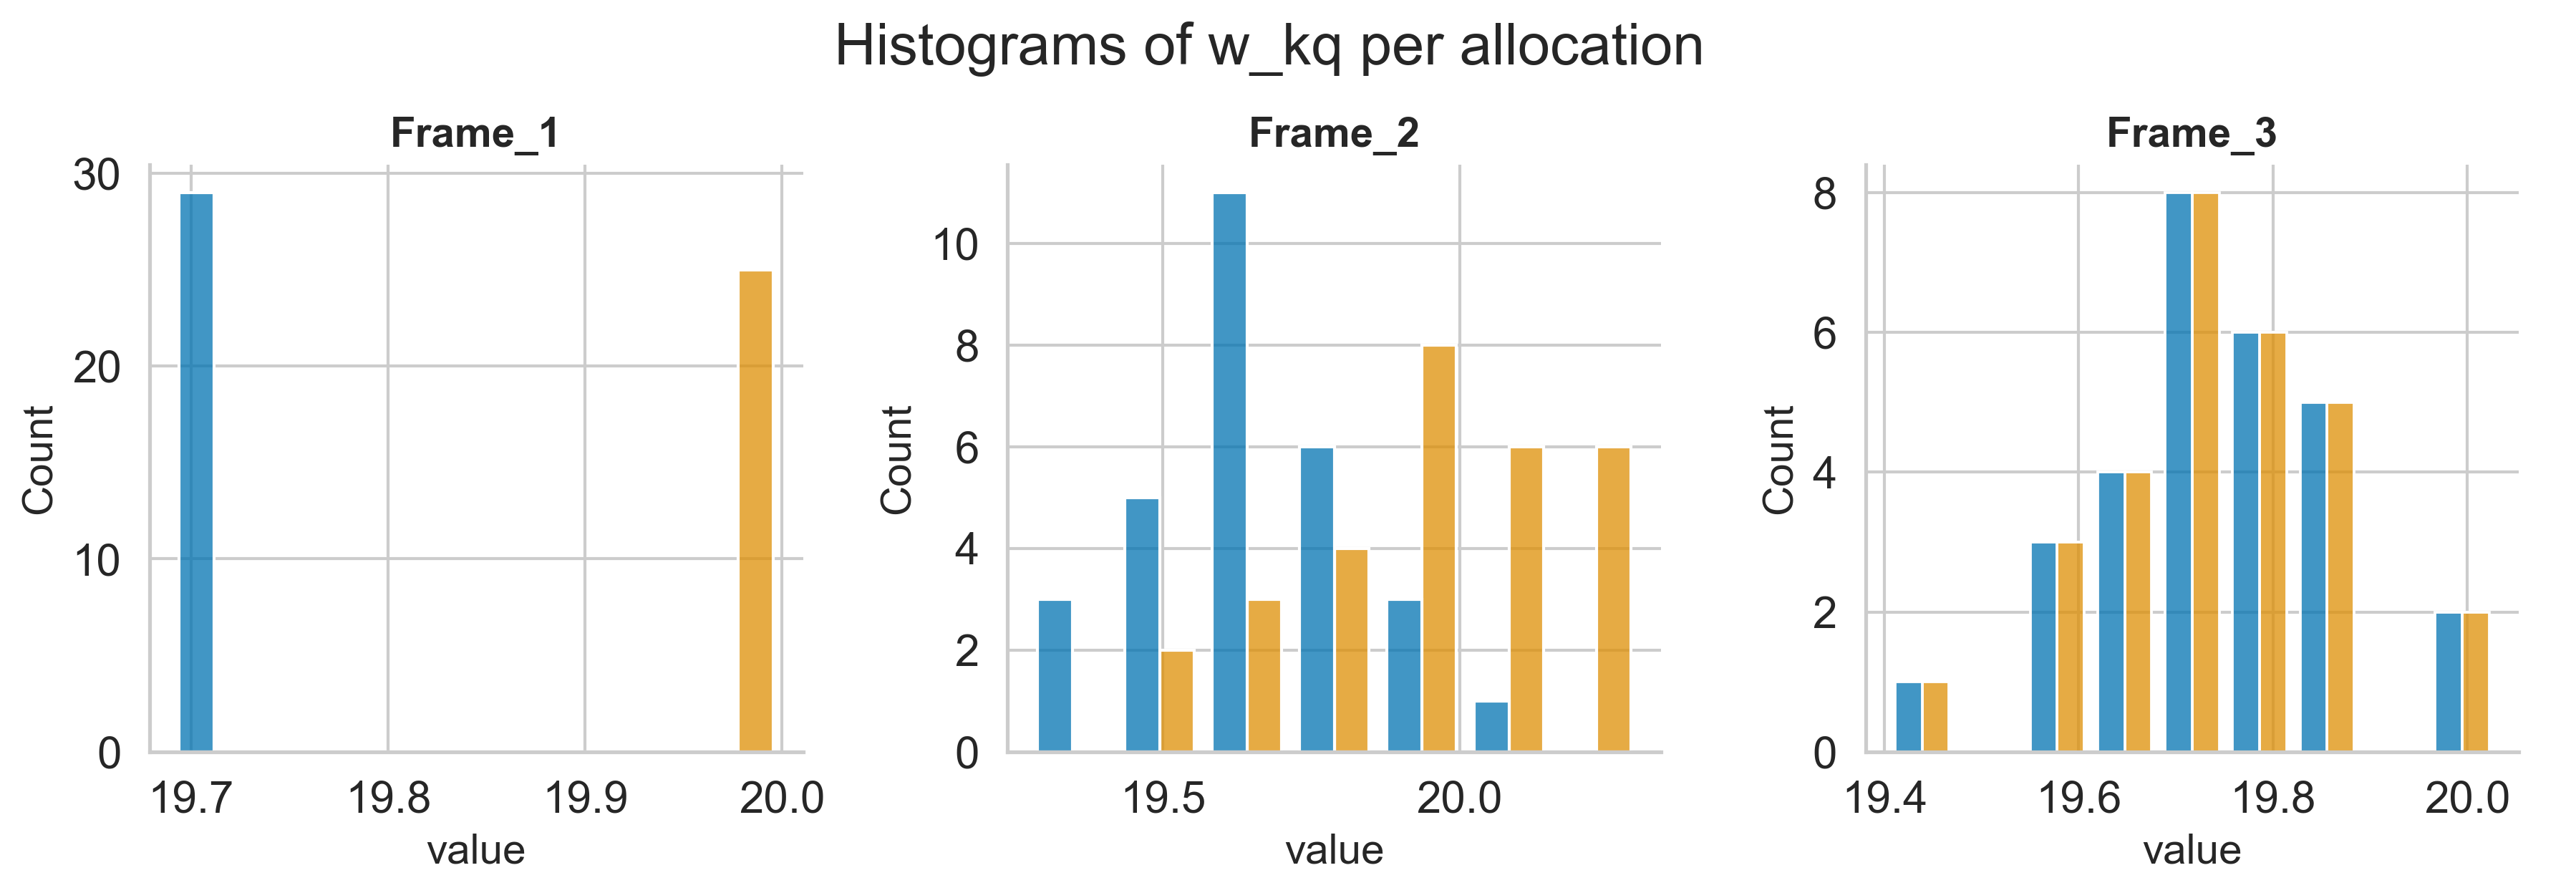

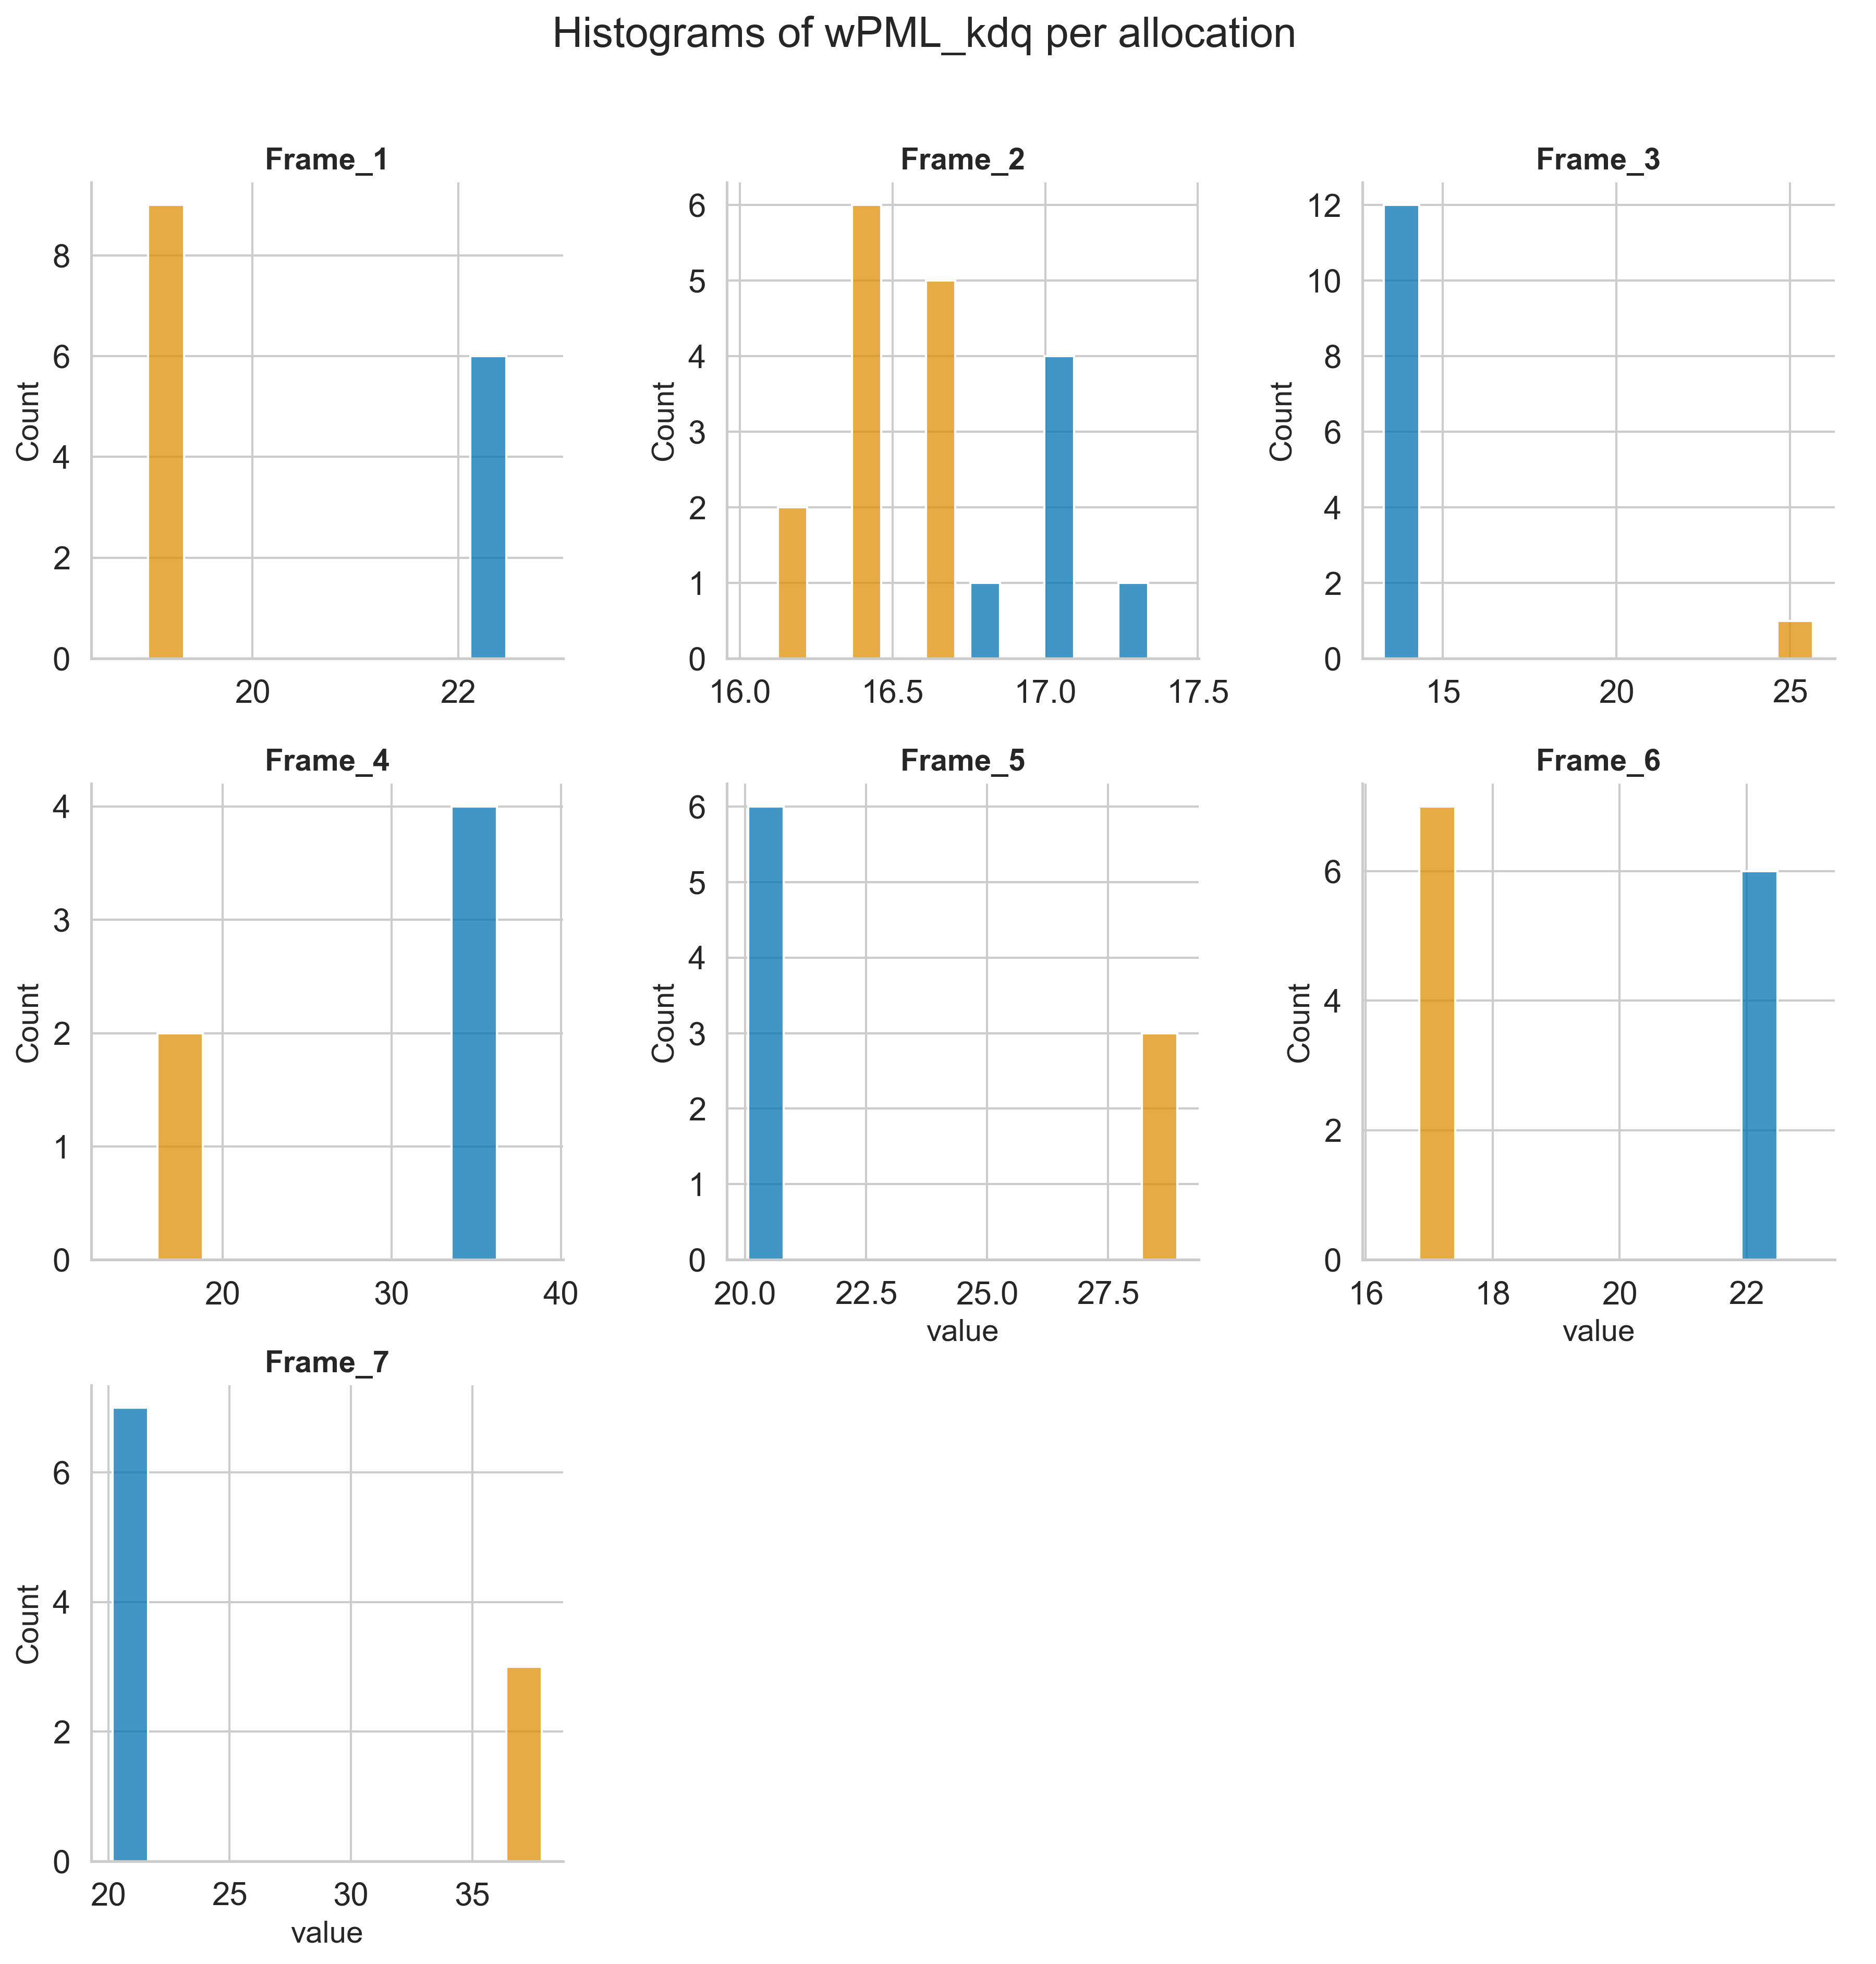

,dataset,group,modality,value
0,wPML_kdq,Frame_1,equal,22.900031
1,wPML_kdq,Frame_1,equal,22.900031
2,wPML_kdq,Frame_1,equal,22.900031
3,wPML_kdq,Frame_1,equal,22.900031
4,wPML_kdq,Frame_1,equal,22.900031
...,...,...,...,...
80,wPML_kdq,Frame_7,equal,19.884976
81,wPML_kdq,Frame_7,equal,19.981536
82,wPML_kdq,Frame_7,optimal_cost,37.475243
83,wPML_kdq,Frame_7,optimal_cost,38.233431


In [11]:
def plot_weights_histograms(data_dict, dataset_name, bins=20, normalize=False, save: Optional[str] = None):
    """
    Plot histograms per group and modality from a nested dictionary of data.
    
    Parameters
    ----------
    data_dict : dict
        Dictionary of the form:
        {
          "group1": {"mod1": array_like, "mod2": array_like, ...},
          "group2": {"mod1": array_like, ...},
          ...
        }
    dataset_name : str
        Name of the dataset (used for plot title).
    bins : int, optional
        Number of histogram bins (default=20).
    normalize : bool, optional
        If True, normalize histograms to density instead of counts.
    """
    # ---- reshape to tidy DataFrame ----
    rows = []
    for group, mod_dict in data_dict.items():
        for mod, vals in mod_dict.items():
            for v in vals:
                rows.append([dataset_name, group, mod, v])
    df = pd.DataFrame(rows, columns=["dataset", "group", "modality", "value"])
    
    # ---- plotting ----
    g = sns.FacetGrid(
        df, col="group", col_wrap=3, sharex=False, sharey=False, height=4
    )
    g.map_dataframe(
        sns.histplot,
        x="value",
        hue="modality",
        multiple="dodge",   # side-by-side bars
        bins="auto",
        stat="density" if normalize else "count",  # counts or density
        shrink=0.8
    )
    g.add_legend()
    g.set_titles("{col_name}")
    g.fig.suptitle(f"Histograms of {dataset_name} per allocation", y=1.05)

    if save:
        plt.savefig(save, bbox_inches= "tight")
    
    plt.show()
    
    return df  # return tidy dataframe in case you want to reuse it


data_for_wkq = {"Frame_1": {"equal":simulation_init_results["estimates"]["w_kq"][0],
                            "optimal_cost": simulation_init_results_opt["estimates"]["w_kq"][0]},
"Frame_2": {"equal":simulation_init_results["estimates"]["w_kq"][1], "optimal_cost": simulation_init_results_opt["estimates"]["w_kq"][1]},
 "Frame_3": {"equal":simulation_init_results["estimates"]["w_kq"][2], "optimal_cost": simulation_init_results["estimates"]["w_kq"][2]}
} 

plot_weights_histograms(data_for_wkq, "w_kq", save= "hist_wkq.pdf")

###
data_for_wPML_kqd = {"Frame_1": {"equal":simulation_init_results["estimates"]["wPML_kdq"][0], 
                                "optimal_cost":simulation_init_results_opt["estimates"]["wPML_kdq"][0]},
"Frame_2": {"equal":simulation_init_results["estimates"]["wPML_kdq"][1], 
           "optimal_cost":simulation_init_results_opt["estimates"]["wPML_kdq"][1]},
 "Frame_3": {"equal":simulation_init_results["estimates"]["wPML_kdq"][2], "optimal_cost":simulation_init_results_opt["estimates"]["wPML_kdq"][2]},
"Frame_4": {"equal":simulation_init_results["estimates"]["wPML_kdq"][3], "optimal_cost":simulation_init_results_opt["estimates"]["wPML_kdq"][3]},
"Frame_5": {"equal":simulation_init_results["estimates"]["wPML_kdq"][4], "optimal_cost":simulation_init_results_opt["estimates"]["wPML_kdq"][4]},
"Frame_6": {"equal":simulation_init_results["estimates"]["wPML_kdq"][5], "optimal_cost":simulation_init_results_opt["estimates"]["wPML_kdq"][5]},
"Frame_7": {"equal":simulation_init_results["estimates"]["wPML_kdq"][6], "optimal_cost":simulation_init_results_opt["estimates"]["wPML_kdq"][6]}
                    }
plot_weights_histograms(data_for_wPML_kqd, "wPML_kdq", save= "hist_wPML_kdq.pdf")

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

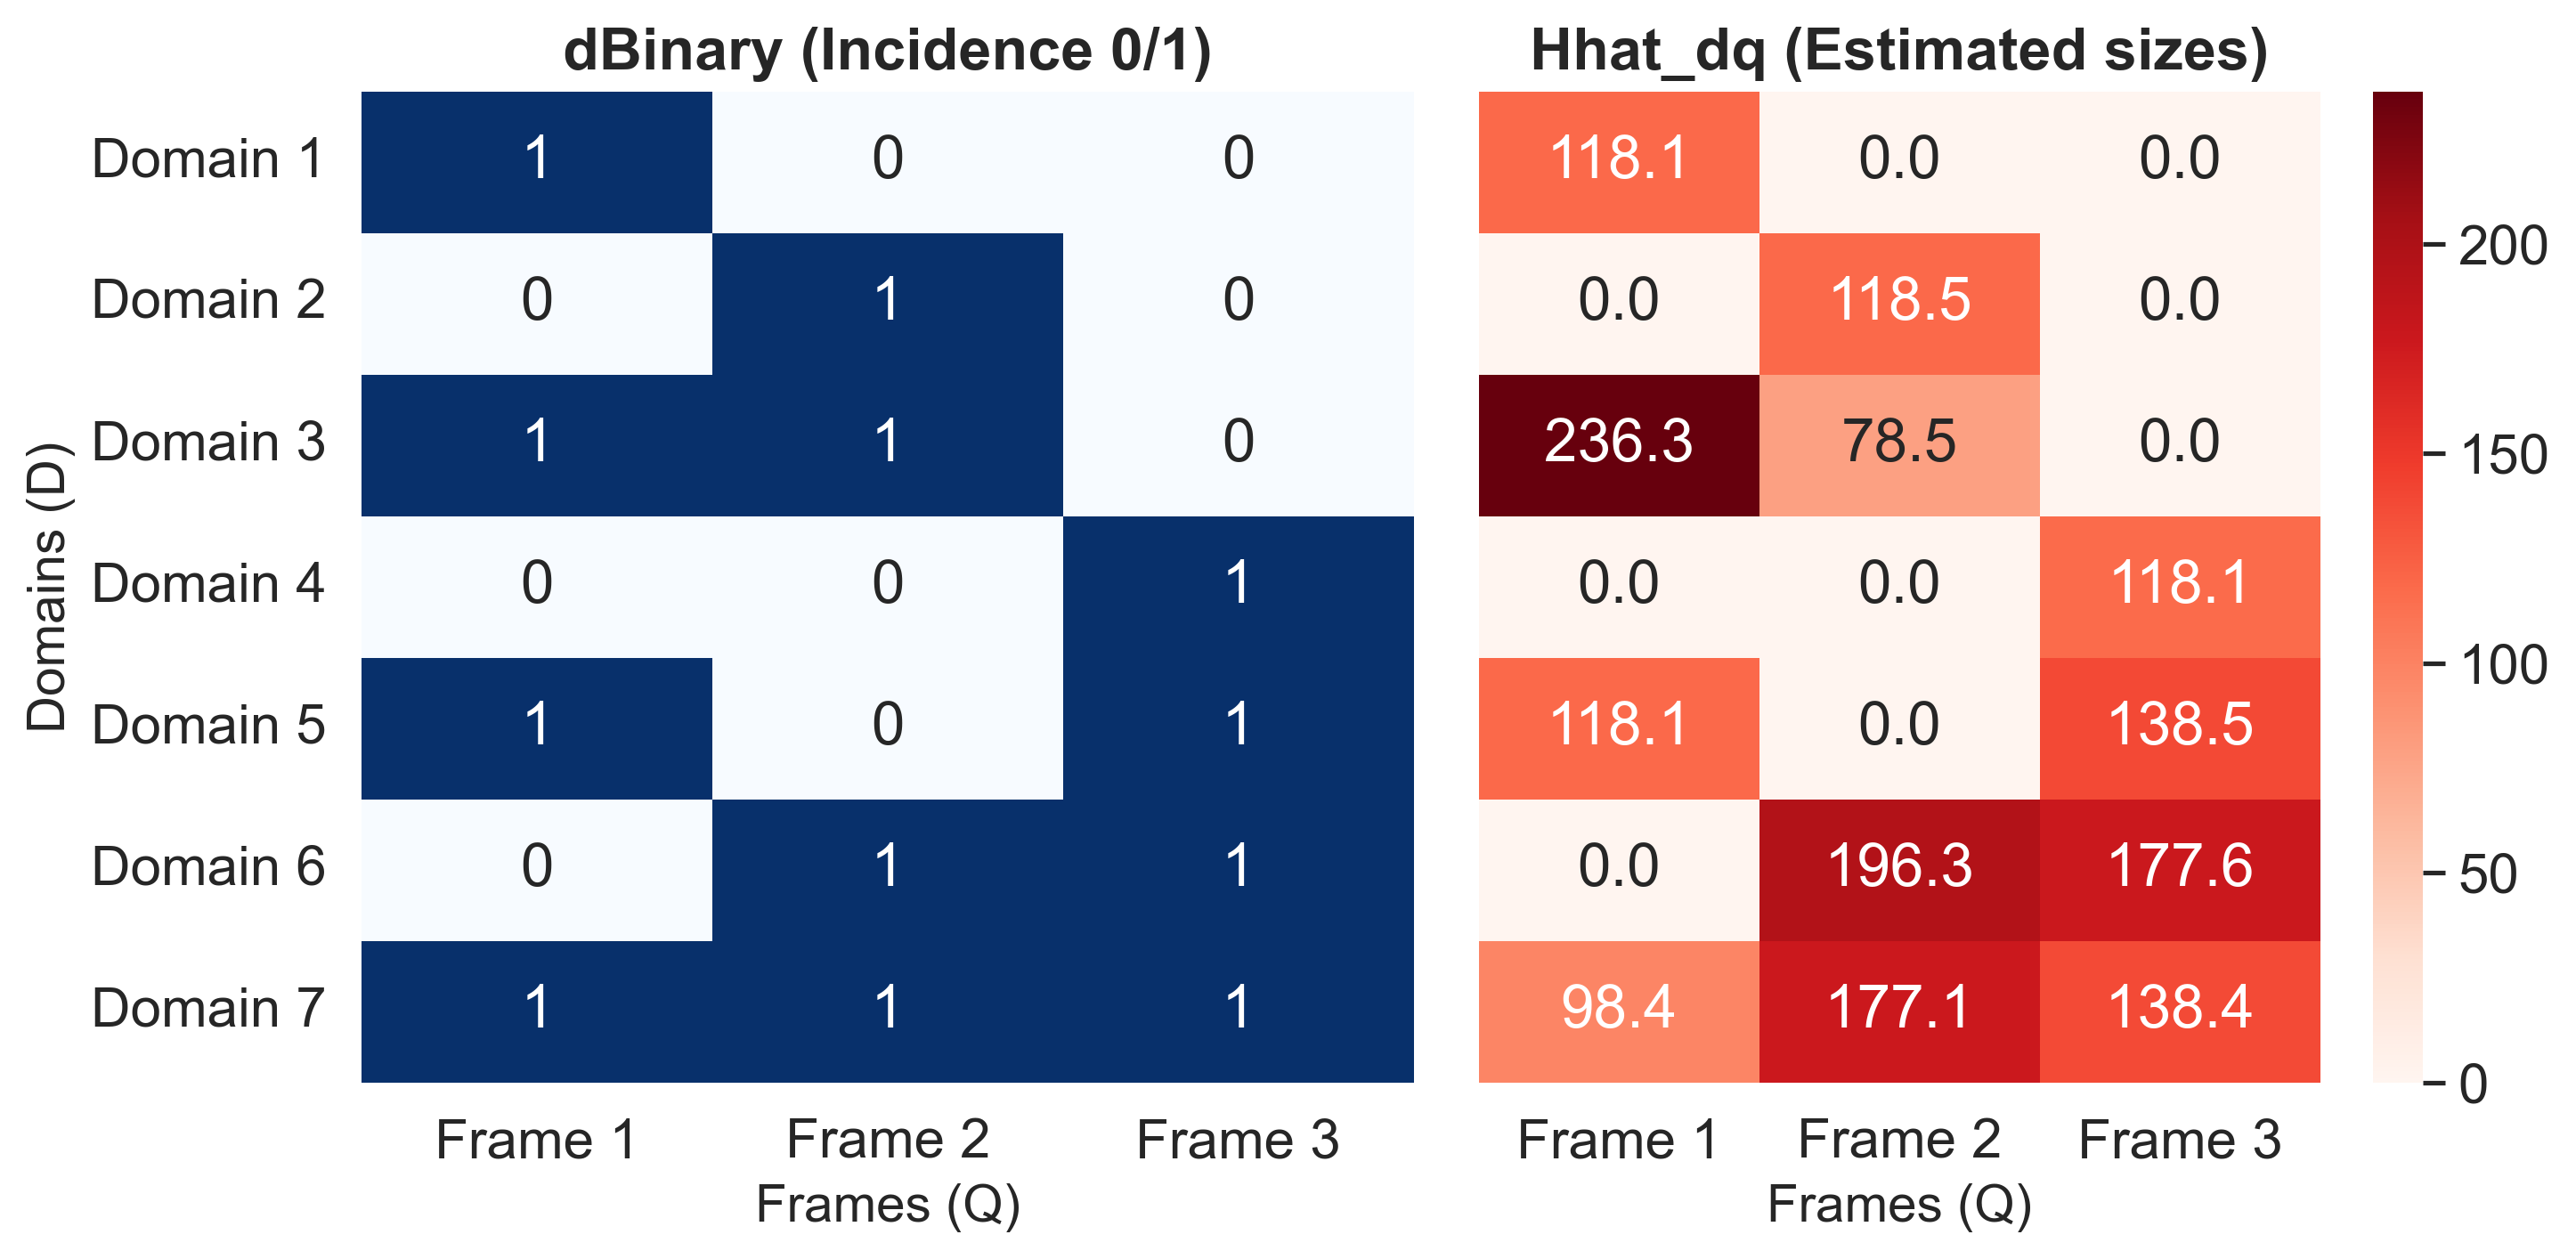

In [12]:
def compare_heatmap(Hhat_dq, dBinary, Q= 3, save: Optional[str]= None):
    """
    Compare Hhat_dq and dBinary with heatmaps side by side.
    
    Parameters
    ----------
    Hhat_dq : array-like (D x Q)
        Estimated domain-frame matrix.
    dBinary : array-like (D x Q)
        Incidence (0/1) matrix.
    """
    
    D = 2**Q -1
    
    df_Hhat = pd.DataFrame(Hhat_dq, 
                           index=[f"Domain {d+1}" for d in range(D)], 
                           columns=[f"Frame {q+1}" for q in range(Q)])
    df_dBin = pd.DataFrame(dBinary, 
                           index=[f"Domain {d+1}" for d in range(D)], 
                           columns=[f"Frame {q+1}" for q in range(Q)])

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    
    sns.heatmap(df_dBin, annot=True, cmap="Blues", cbar=False, ax=axes[0])
    axes[0].set_title("dBinary (Incidence 0/1)")
    axes[0].set_xlabel("Frames (Q)")
    axes[0].set_ylabel("Domains (D)")
    
    sns.heatmap(df_Hhat, annot=True, fmt=".1f", cmap="Reds", ax=axes[1])
    axes[1].set_title("Hhat_dq (Estimated sizes)")
    axes[1].set_xlabel("Frames (Q)")
    
    plt.tight_layout()
    if save:
        plt.save(save, bbox_inches= "tight")
    plt.show()


compare_heatmap(Hhat_dq= simulation_init_results["estimates"]["Hhat_dq"],
                dBinary= simulation_init_results["population"]["dBinary"], save= "heatmap_equal.pdf")

In [ ]:
compare_heatmap(Hhat_dq= simulation_init_results_opt["estimates"]["Hhat_dq"],
                dBinary= simulation_init_results_opt["population"]["dBinary"], save= "heatmap_optimal_cost.pdf")